# Exploring the Large Database (19,769 edits)

This notebook focuses on the **exploratory analysis and visualisation** of the cleaned and preprocessed dataset produced in the `preprocessing_full_db.ipynb` notebook.  
Its purpose is to develop an initial, data-driven understanding of **who edits, what is edited, and how editing activity is structured over time and across user types** for the large database.

This notebook is then a kind of copy paste of the ```exploring.ipynb``` created for the small database.

---

## Scope of the Exploration

Using the preprocessed dataframe, this notebook explores several complementary dimensions of the data:

### 1. Users
- Distribution of edits by user and by user type (Registered, Anonymous (IP), Bot)
- Identification of highly active users
- Relative contribution of different user types to the dataset

### 2. Articles
- Most frequently edited articles
- Distribution of edits across articles
- Concentration of editorial activity on a small subset of pages

This helps identify **core articles** and potential focal points of controversy or strategic editing.

### 3. Temporal Distribution of Edits
- Number of edits over time (yearly evolution)
- Comparison of activity patterns across user types
- Detection of peaks or shifts in editing behaviour

Temporal analysis provides context for linking editorial activity to **external events or long-term trends**.

### 4. Edit Comments
- Presence and absence of edit comments
- Proportion of missing comments by user type
- Proportion of missing comments by both user type and edit type (weaponised vs not weaponised)

Edit comments are analysed as indicators of **editorial transparency, coordination, and accountability**.

### 5. Spatio-Temporal Heatmaps of Editing Activity

To capture fine-grained temporal patterns, the notebook includes several heatmaps:

- **Edits by year and weekday**
- **Edits by weekday and user type**
- Comparative heatmaps highlighting differences between weaponised and non-weaponised contexts

These visualisations reveal **rhythms of activity**, such as:
- weekday vs weekend behaviour,
- regularity vs burstiness,
- and differences in temporal strategies across user categories.

## Methodological Note

> **Note**  
> An initial, informal exploration phase was conducted prior to this notebook in order to identify appropriate cleaning and preprocessing strategies.  
> This early exploratory work is intentionally not documented here, in order to keep the analysis pipeline **lightweight, focused, and reproducible**.

## Research Objective

The goal of this exploratory notebook is not to test hypotheses, but to **surface patterns, anomalies, and structural regularities** in the data.  
These observations guide:
- subsequent analytical choices,
- feature selection,
- and the interpretation of behavioural signals related to **weaponisation and editorial dynamics**.

Ultimately, this exploratory step supports the extraction of robust, interpretable features for the development of a downstream **Large Language Model (LLM)** aimed at analysing or detecting coordinated or manipulative editing behaviour on Wikipedia.


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from tqdm import tqdm
from wikipedia_api import *

In [13]:
df_preprocessed = pd.read_csv('../../datas/final/large_db_preprocess.csv')

In [14]:
df_preprocessed

,initial_version,changed_version,comment,user,date,llm_output,weaponised,article,user_type
0,{{main|2020 coronavirus outbreak in Europe}}\n...,Initial revision,create page,Dying,2020-03-03T23:46:58Z,Added initial revision content.\n\nNot Weaponi...,Not Weaponised,COVID-19 pandemic in Ukraine,Registered
1,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -10,7 +10,7 @@\n | virus_strain...",changed arrival_date 2020.03.03 in [[Template:...,Neo-Jay,2020-03-04T00:05:02Z,"Changed the format of the arrival date from ""2...",Not Weaponised,COVID-19 pandemic in Ukraine,Registered
2,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -17,7 +17,7 @@\n \n == Timeline...",NaN,Unlogged by Anti-1337 People,2020-03-11T10:54:13Z,"Changed the date from ""27 January 2020"" to ""27...",Not Weaponised,COVID-19 pandemic in Ukraine,Registered
3,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -17,7 +17,7 @@\n | recovery_cas...",NaN,1857a,2020-03-04T00:54:47Z,"Changed the date format from ""2020.03.03"" to ""...",Not Weaponised,COVID-19 pandemic in Ukraine,Registered
4,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -1,5 +1,3 @@\n-{{see also|2019–...",/* top */ [[WP:HATNOTES|hatnotes]] are used if...,Uanfala,2020-03-05T19:12:54Z,Removed two hatnote templates related to the 2...,Not Weaponised,COVID-19 pandemic in Ukraine,Registered
...,...,...,...,...,...,...,...,...,...
69897,{{under construction}}\n{{Infobox civil confli...,"--- \n+++ \n@@ -101,7 +101,7 @@\n Ukrainians h...",[[Yuriy Lutsenko]],Nickst,2013-12-25T18:38:02Z,"Changed ""Yuri Lutsenko"" to ""Yuriy Lutsenko"" in...",Not Weaponised,Euromaidan,Registered
69898,{{under construction}}\n{{Infobox civil confli...,"--- \n+++ \n@@ -376,7 +376,7 @@\n \n On 9 Dece...",/* Protests across Ukraine */,Lvivske,2013-12-26T00:29:34Z,"The change made is: ""Rephrased the number of t...",Weaponised,Euromaidan,Registered
69899,{{under construction}}\n{{Infobox civil confli...,"--- \n+++ \n@@ -274,7 +274,7 @@\n \n On 24 Dec...",/* 18 December–present */,Lvivske,2013-12-25T19:25:39Z,The change made is the addition of the phrase ...,Not Weaponised,Euromaidan,Registered
69900,{{under construction}}\n{{Infobox civil confli...,"--- \n+++ \n@@ -274,7 +274,7 @@\n \n On 24 Dec...",/* 18 December–present */,Lvivske,2013-12-25T23:28:06Z,The change made is a rephrasing of a statement...,Weaponised,Euromaidan,Registered


In [15]:
dataframe_metadata = {
    # Overall dataset size
    "total_edits": len(df_preprocessed),
    "total_unique_users": df_preprocessed["user"].nunique(),
    "number_unique_articles": df_preprocessed["article"].nunique(),

    # User type counts (unique users)
    "num_bot_users": df_preprocessed.loc[df_preprocessed["user_type"] == "Bot", "user"].nunique(),
    "num_anonymous_users": df_preprocessed.loc[df_preprocessed["user_type"] == "Anonymous (IP)", "user"].nunique(),
    "num_registered_users": df_preprocessed.loc[df_preprocessed["user_type"] == "Registered", "user"].nunique(),

    # Edit counts by user type (just count rows)
    "num_bot_edits": int((df_preprocessed["user_type"] == "Bot").sum()),
    "num_anonymous_edits": int((df_preprocessed["user_type"] == "Anonymous (IP)").sum()),
    "num_registered_edits": int((df_preprocessed["user_type"] == "Registered").sum()),

    # Weaponisation counts
    "weaponised_edits": int((df_preprocessed["weaponised"] == "Weaponised").sum()),
    "non_weaponised_edits": int((df_preprocessed["weaponised"] == "Not Weaponised").sum())
}

dataframe_metadata

{'total_edits': 69902,
 'total_unique_users': 19769,
 'number_unique_articles': 40,
 'num_bot_users': 65,
 'num_anonymous_users': 10609,
 'num_registered_users': 9095,
 'num_bot_edits': 2926,
 'num_anonymous_edits': 17818,
 'num_registered_edits': 49158,
 'weaponised_edits': 13444,
 'non_weaponised_edits': 56458}

## Plots to show some distribution

The following plots help to understand better how the edits are distributed over time and across the different user types. The different user types we are dealing with in the first place are Registered, Bot and IP users. Registered users are user that has an account on Wikipedia and can be identified by an ```user_id``` and a ```username``` while the IP user doesn't have an account. One can identify him only by his ```IP adress```. 

The plots are displayed as the following :
* Weaponised vs Non-Weaponised Edits per Year
* Weaponised vs Non-Weaponised Edits by User Type
* Weaponised vs Non-Weaponised Edits per Year for Top 10 Users
* Proportion of Missing Comments by User Type
* Heatmap of Weaponised Edits per Day per Group over every year
* Heatmap of Weaponised Edits per Weekday per Group over every year

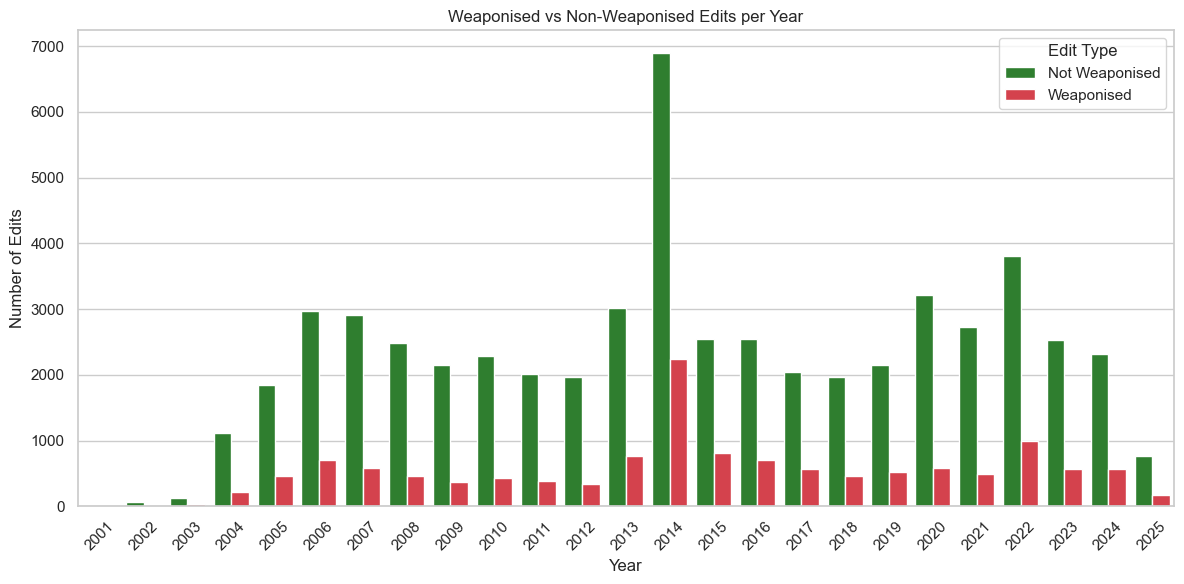

weaponised,Not Weaponised,Weaponised
year,,
2001,8.0,NaN
2002,64.0,10.0
2003,130.0,32.0
2004,1123.0,224.0
2005,1839.0,454.0
2006,2975.0,712.0
2007,2910.0,587.0
2008,2479.0,457.0
2009,2147.0,371.0


In [16]:
def plot_weap_vs_not_weap_per_year(dataframe, wanna_save=False):

    df = dataframe.copy()
    # Extract year
    df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

    # Group counts
    df_counts = (
        df.groupby(["year", "weaponised"])
          .size()
          .reset_index(name="count")
    )

    custom_palette = {
        "Weaponised": "#ed2939",      # red
        "Not Weaponised": "forestgreen",  # royal blue
    }

    # Plot
    sns.set_style("whitegrid")
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_counts,
        x="year",
        y="count",
        hue="weaponised",
        palette=custom_palette
    )

    plt.title("Weaponised vs Non-Weaponised Edits per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Edits")
    plt.legend(title="Edit Type")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/Full Database/Weaponised vs Non-Weaponised Edits per Year.png",
            dpi=300,
            bbox_inches='tight'
        )
    plt.show()

    return df_counts.pivot(index="year", columns="weaponised", values="count")

df_counts = plot_weap_vs_not_weap_per_year(df_preprocessed, wanna_save=False)
df_counts

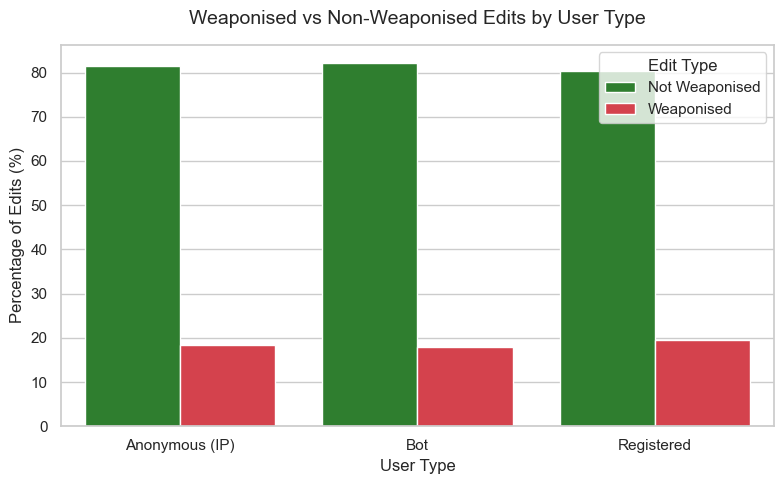

weaponised,Not Weaponised,Weaponised
user_type,,
Anonymous (IP),14532,3286
Bot,2404,522
Registered,39522,9636


In [17]:
def plot_weap_vs_not_weap_per_user_type(dataframe, wanna_save=False):

    comparison = (
        dataframe.groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="count")
    )
    
    # Compute total edits per user type and percentage of weaponised edits
    totals = comparison.groupby("user_type")["count"].sum().reset_index(name="total")
    comparison = comparison.merge(totals, on="user_type")
    comparison["percentage"] = (comparison["count"] / comparison["total"]) * 100
    
    custom_palette = {
        "Weaponised": "#ed2939",      # red
        "Not Weaponised": "forestgreen",   # royal blue
    }
    
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=comparison,
        x="user_type",
        y="percentage",
        hue="weaponised",
        palette=custom_palette
    )
    
    plt.title("Weaponised vs Non-Weaponised Edits by User Type", fontsize=14, pad=15)
    plt.xlabel("User Type", fontsize=12)
    plt.ylabel("Percentage of Edits (%)", fontsize=12)
    plt.legend(title="Edit Type")
    plt.tight_layout()
    fig_title = 'Weaponised vs Non-Weaponised Edits by User Type'
    if wanna_save:
        plt.savefig(f"../../plots/Full Database/{fig_title}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return comparison.pivot(columns='weaponised', index='user_type', values='count')

comparison = plot_weap_vs_not_weap_per_user_type(df_preprocessed, False)
comparison

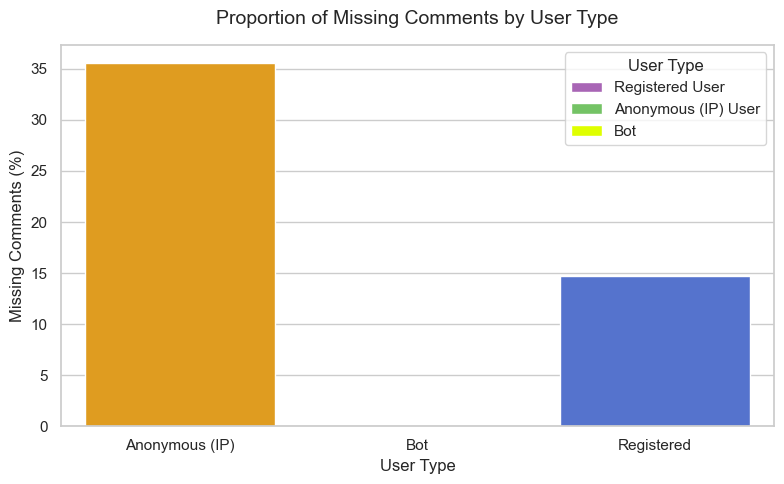

In [18]:
def plot_missing_comment_per_user_type(dataframe, wanna_save=False):

    missing = (
        dataframe[dataframe["comment"].isna()]
        .groupby("user_type")
        .size()
        .reset_index(name="missing_count")
    )
    
    total = (
        dataframe.groupby("user_type")
        .size()
        .reset_index(name="total_count")
    )
    comparison = missing.merge(total, on="user_type", how="right").fillna(0)
    comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100
    
    comparison = comparison[comparison["user_type"].isin(["Registered", "Anonymous (IP)", "Bot"])]
    
    custom_palette = {
        "Registered": "royalblue",      
        "Anonymous (IP)": "orange", 
        "Bot": "#dfff00"
    }
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    
    sns.barplot(
        data=comparison,
        x="user_type",
        y="missing_percentage",
        hue='user_type',
        palette=custom_palette
    )
    
    plt.title("Proportion of Missing Comments by User Type", fontsize=14, pad=15)
    plt.xlabel("User Type", fontsize=12)
    plt.ylabel("Missing Comments (%)", fontsize=12)
    plt.tight_layout()
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="#a865b5", label="Registered User"),
        Patch(facecolor="#74c365", label="Anonymous (IP) User"),
        Patch(facecolor="#dfff00", label="Bot")
    ]
    plt.legend(
        handles=legend_elements,
        title="User Type",
        loc="upper right",
        frameon=True
    )
    fig_title = "Proportion of Missing Comments by User Type"
    if wanna_save:
        plt.savefig(f"../../plots/Full Database/{fig_title}.png", dpi=300, bbox_inches="tight")
        
    plt.show()

plot_missing_comment_per_user_type(df_preprocessed, False)

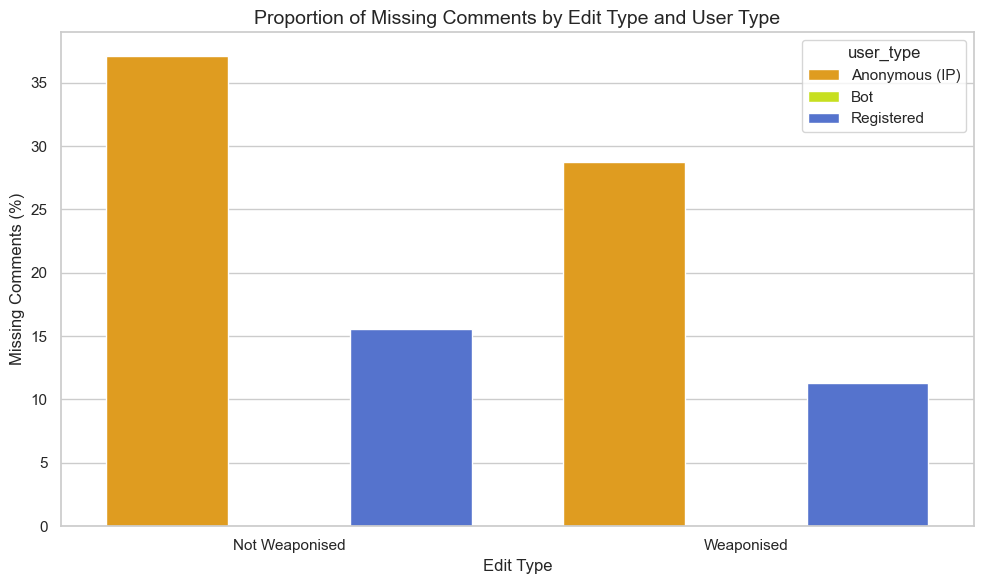

In [20]:
def plot_missing_comment_user_type_edit_type(dataframe, wanna_save=False):
    
    custom_palette = {
        "Registered": "royalblue",
        "Anonymous (IP)": "orange",
        "Bot": "#dfff00"
    }
    
    missing = (
        dataframe[dataframe["comment"].isna()]
        .groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="missing_count")
    )
    
    # Total edits per edit type
    total = (
        dataframe.groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="total_count")
    )
    
    # Merge & compute proportions
    comparison = total.merge(missing, on=["user_type", "weaponised"], how="left")
    comparison["missing_count"] = comparison["missing_count"].fillna(0)
    comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    sns.barplot(
        data=comparison,
        x="weaponised",
        y="missing_percentage",
        hue="user_type",
        palette=custom_palette
    )
    
    plt.title("Proportion of Missing Comments by Edit Type and User Type", fontsize=14)
    plt.xlabel("Edit Type", fontsize=12)
    plt.ylabel("Missing Comments (%)", fontsize=12)
    plt.tight_layout()
    
    
    fig_title = "Proportion of Missing Comments by Edit Type and User Type"
    if wanna_save:
        plt.savefig(f"../../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_missing_comment_user_type_edit_type(df_preprocessed, False)

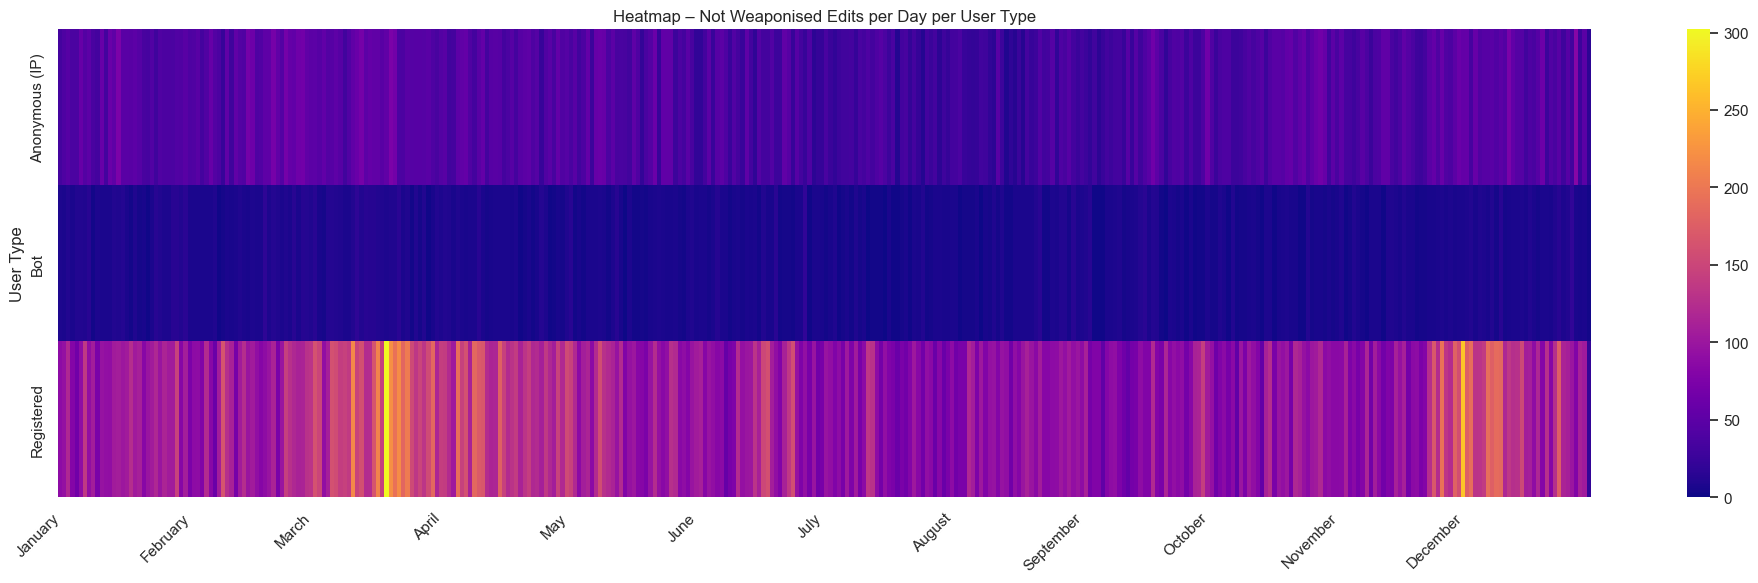

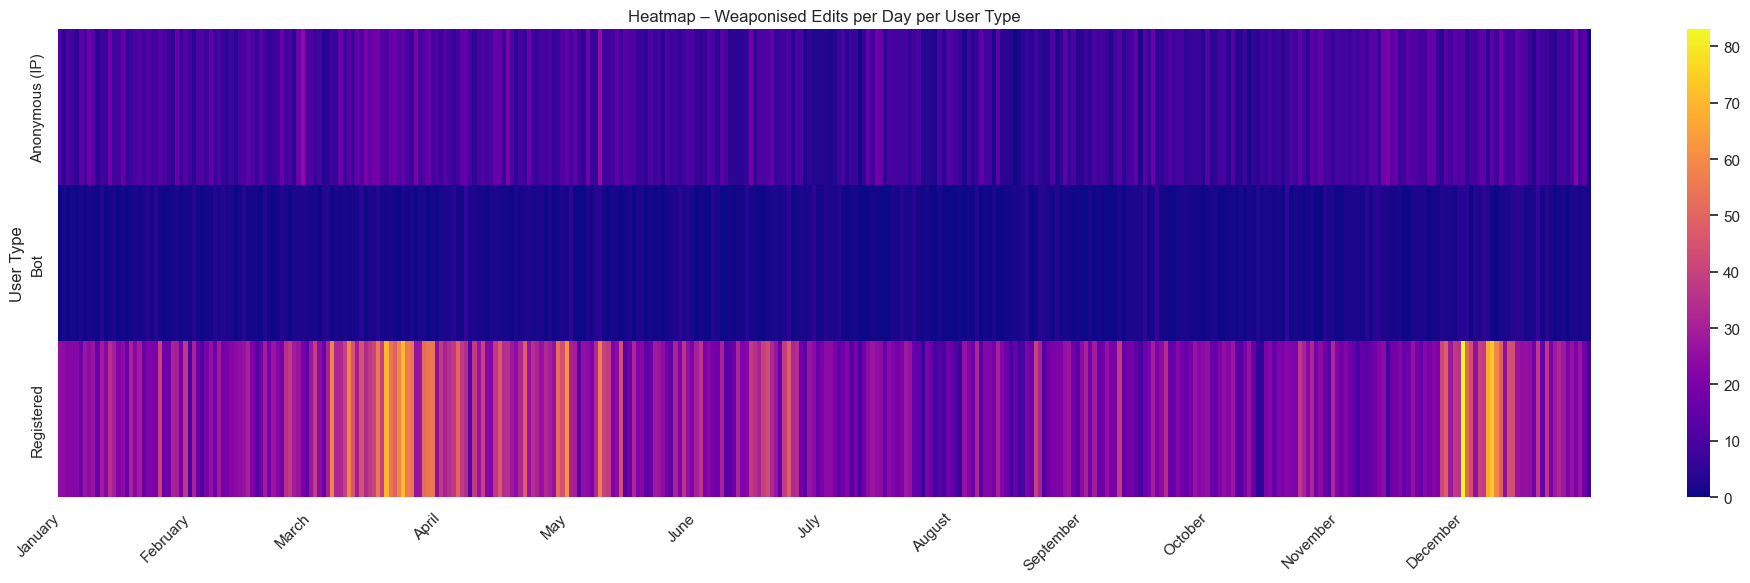

In [13]:
def plot_heatmaps(dataframe, wanna_save=False):

    df = dataframe.copy()
    dt = pd.to_datetime(df["date"], errors="coerce")
    df["date"] = dt.dt.date
    df["doy"] = dt.dt.dayofyear
    
    df_not_weap = df[df["weaponised"] == "Not Weaponised"].copy()
    df_weap     = df[df["weaponised"] != "Not Weaponised"].copy()

    daily_not_weap = (
        df_not_weap.groupby(["user_type", "date"])
        .size()
        .reset_index(name="count")
    )

    daily_weap = (
        df_weap.groupby(["user_type", "date"])
        .size()
        .reset_index(name="count")
    )


    daily_not_weap["doy"] = pd.to_datetime(daily_not_weap["date"]).dt.dayofyear
    daily_weap["doy"]     = pd.to_datetime(daily_weap["date"]).dt.dayofyear


    hm_not_weap = daily_not_weap.pivot_table(
        index="user_type", columns="doy", values="count", aggfunc="sum"
    ).fillna(0)

    hm_weap = daily_weap.pivot_table(
        index="user_type", columns="doy", values="count", aggfunc="sum"
    ).fillna(0)

    
    hm_not_weap = hm_not_weap.reindex(columns=range(1, 367), fill_value=0)
    hm_weap     = hm_weap.reindex(columns=range(1, 367), fill_value=0)

    
    month_starts = [pd.Timestamp(f"2024-{m:02d}-01").dayofyear for m in range(1, 13)]
    month_names = [calendar.month_name[m] for m in range(1, 13)]

    
    plt.figure(figsize=(20, 6))
    sns.heatmap(hm_not_weap, cmap="plasma", cbar=True)

    plt.xticks(month_starts, month_names, rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("User Type")
    plt.title("Heatmap – Not Weaponised Edits per Day per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig("../../plots/Full Database/Heatmap_Not_Weaponised.png",
                    dpi=300, bbox_inches="tight")
    plt.show()

    
    plt.figure(figsize=(20, 6))
    sns.heatmap(hm_weap, cmap="plasma", cbar=True)

    plt.xticks(month_starts, month_names, rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("User Type")
    plt.title("Heatmap – Weaponised Edits per Day per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig("../../plots/Full Database/Heatmap_Weaponised.png",
                    dpi=300, bbox_inches="tight")
    plt.show()

    return hm_not_weap, hm_weap

hm_not, hm_weap = plot_heatmaps(df_preprocessed)

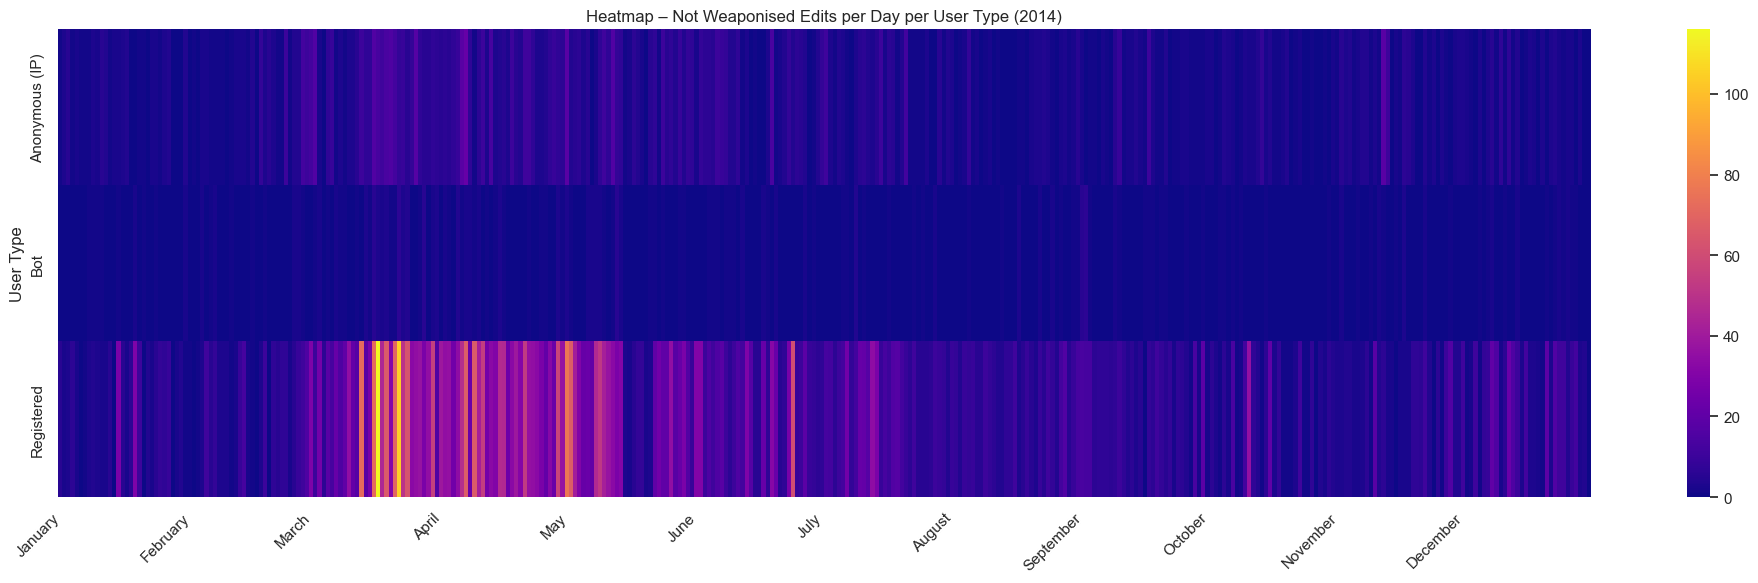

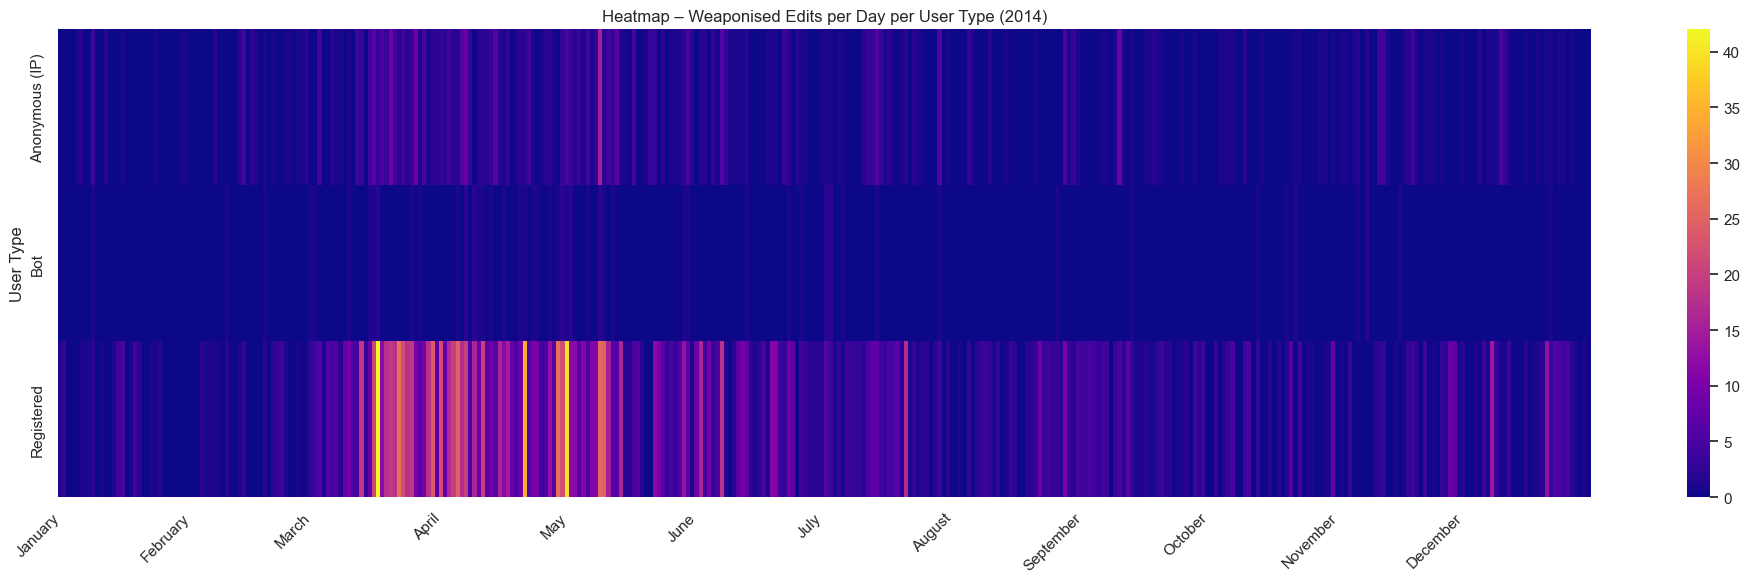

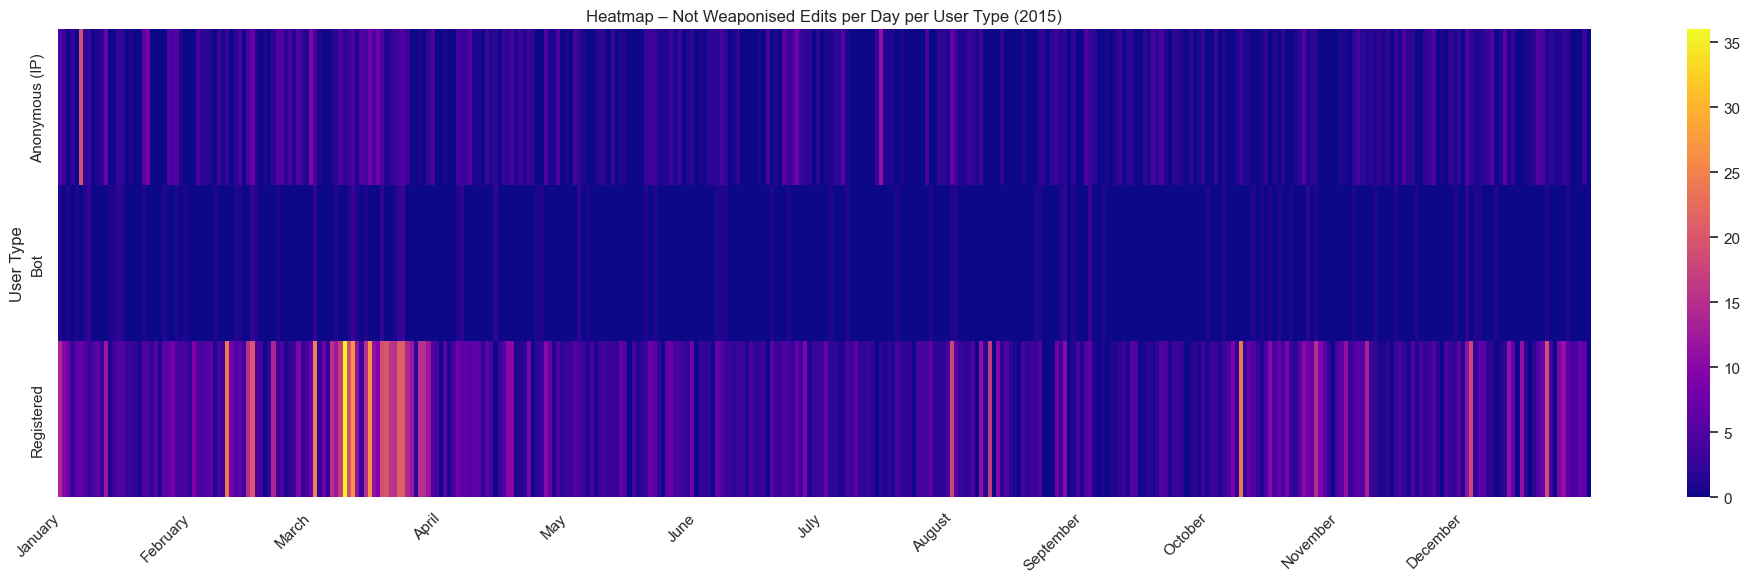

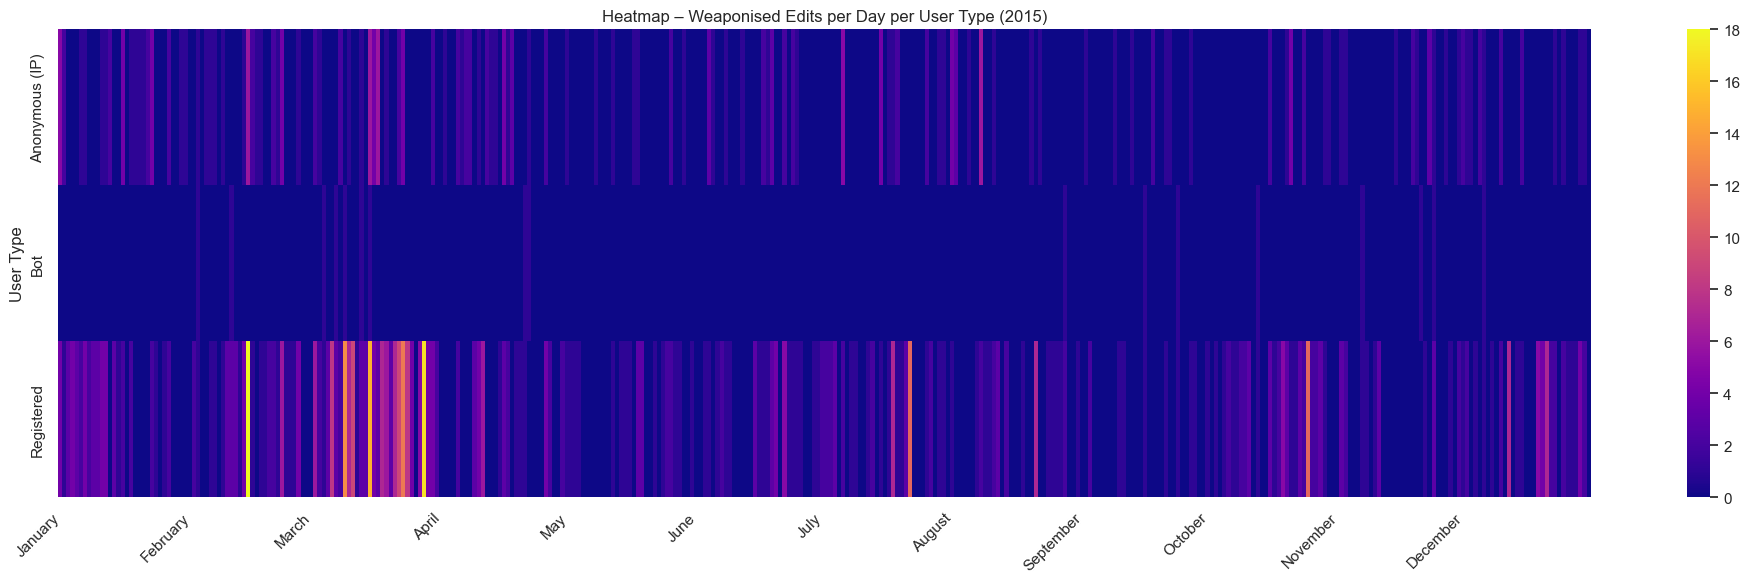

In [9]:
def plot_heatmaps_years(dataframe, years="all", wanna_save=False):

    dataframe = dataframe.copy()
    dt = pd.to_datetime(dataframe["date"], errors="coerce")
    dataframe["date"] = dt.dt.date
    dataframe["doy"] = dt.dt.dayofyear
    dataframe["year"] = dt.dt.year

    # The idea is to be able to choose to plot a specific year, all the years from 2001 to 2025 or a subset (2014, 2015, 2016)
    # all years in the range 2001–2025
    if years == "all":
        selected_years = list(range(2001, 2026))
    # single int
    elif isinstance(years, int):
        selected_years = [years]
    # list/tuple of ints
    else:
        selected_years = list(years)

    dataframe = dataframe[dataframe["year"].isin(selected_years)]

    month_starts = [pd.Timestamp(f"2024-{m:02d}-01").dayofyear for m in range(1, 13)]
    month_names = [calendar.month_name[m] for m in range(1, 13)]

    results = {}

    for year in selected_years:
        df_y = dataframe[dataframe["year"] == year]

        if df_y.empty:
            print(f"No data for year {year}. So we continue...")
            continue

        df_not = df_y[df_y["weaponised"] == "Not Weaponised"]
        df_weap = df_y[df_y["weaponised"] != "Not Weaponised"]

        daily_not = (
            df_not.groupby(["user_type", "date"])
            .size()
            .reset_index(name="count")
        )
        daily_weap = (
            df_weap.groupby(["user_type", "date"])
            .size()
            .reset_index(name="count")
        )

        daily_not["doy"] = pd.to_datetime(daily_not["date"]).dt.dayofyear
        daily_weap["doy"] = pd.to_datetime(daily_weap["date"]).dt.dayofyear

       
        hm_not = daily_not.pivot_table(
            index="user_type", columns="doy", values="count", aggfunc="sum"
        ).fillna(0)

        hm_weap = daily_weap.pivot_table(
            index="user_type", columns="doy", values="count", aggfunc="sum"
        ).fillna(0)

        hm_not = hm_not.reindex(columns=range(1, 367), fill_value=0)
        hm_weap = hm_weap.reindex(columns=range(1, 367), fill_value=0)

        if hm_not.empty:
            print(f"No NOT weaponised data for year {year}. Skipping heatmap…")
            
        else:
            plt.figure(figsize=(20, 6))
            sns.heatmap(hm_not, cmap="plasma", cbar=True)
    
            plt.xticks(month_starts, month_names, rotation=45, ha="right")
            plt.ylabel("User Type")
            plt.xlabel("")
            plt.title(f"Heatmap – Not Weaponised Edits per Day per User Type ({year})")
            plt.tight_layout()
    
            if wanna_save:
                plt.savefig(
                    f"../../plots/Full Database/Heatmap_Not_Weaponised_{year}.png",
                    dpi=300,
                    bbox_inches="tight"
                )
            plt.show()

        if hm_weap.empty:
            print(f"No weaponised data for year {year}. Skipping heatmap…")
        
        else:
            plt.figure(figsize=(20, 6))
            sns.heatmap(hm_weap, cmap="plasma", cbar=True)

            plt.xticks(month_starts, month_names, rotation=45, ha="right")
            plt.ylabel("User Type")
            plt.xlabel("")
            plt.title(f"Heatmap – Weaponised Edits per Day per User Type ({year})")
            plt.tight_layout()
    
            if wanna_save:
                plt.savefig(
                    f"../../plots/Full Database/Heatmap_Weaponised_{year}.png",
                    dpi=300,
                    bbox_inches="tight"
                )
            plt.show()

        results[year] = (hm_not, hm_weap)

plot_heatmaps_years(df_preprocessed, years=[i for i in range(2014,2016)], wanna_save=False)

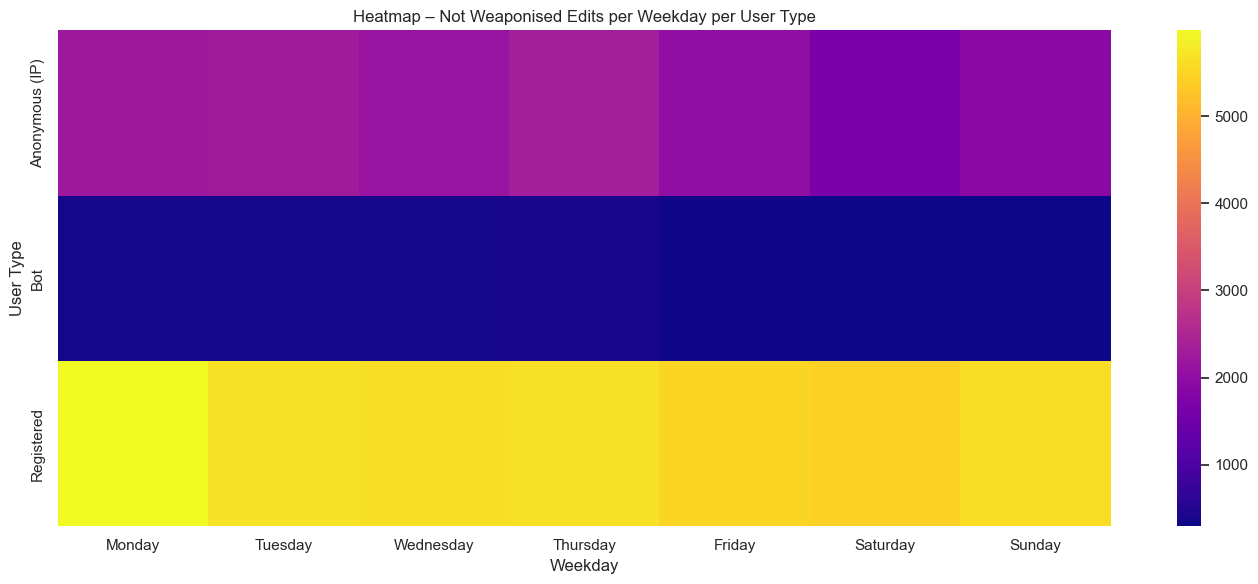

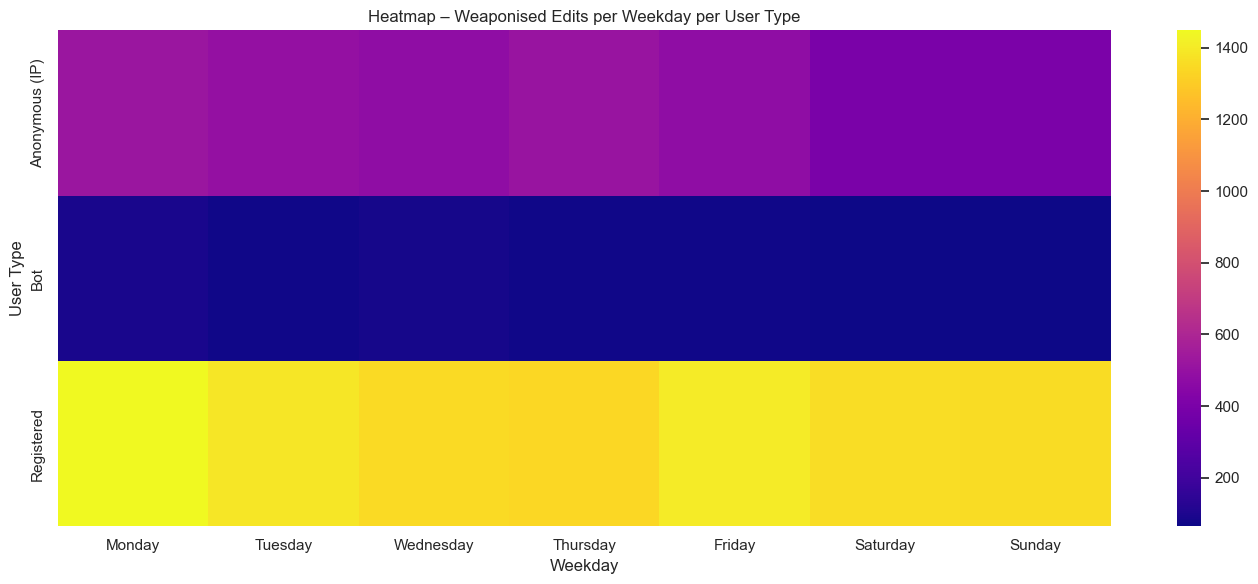

(weekday_name    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
 user_type                                                                     
 Anonymous (IP)    2215     2253       2129      2325    2015      1684    1911
 Bot                369      360        376       386     318       303     292
 Registered        5986     5675       5632      5666    5513      5446    5604,
 weekday_name    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
 user_type                                                                     
 Anonymous (IP)     521      495        480       513     477       398     402
 Bot                 91       71         82        71      75        65      67
 Registered        1448     1386       1350      1337    1402      1357    1356)

In [10]:
def plot_heatmap_weekdays(dataframe, wanna_save=False):
    
    df = dataframe.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["weekday"] = df["date"].dt.weekday          # 0=Mon, 6=Sun
    df["weekday_name"] = df["date"].dt.day_name()

   
    df_not = df[df["weaponised"] == "Not Weaponised"].copy()
    df_weap = df[df["weaponised"] != "Not Weaponised"].copy()

    
    daily_not = (
        df_not.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

    daily_weap = (
        df_weap.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

   
    hm_not = daily_not.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    hm_weap = daily_weap.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    
    ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    hm_not = hm_not.reindex(columns=ordered_days, fill_value=0)
    hm_weap = hm_weap.reindex(columns=ordered_days, fill_value=0)

    
    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_not, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title("Heatmap – Not Weaponised Edits per Weekday per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/Full Database/Heatmap_Weekday_Not_Weaponised.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_weap, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title("Heatmap – Weaponised Edits per Weekday per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/Full Database/Heatmap_Weekday_Weaponised.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    return hm_not, hm_weap

plot_heatmap_weekdays(df_preprocessed, False)

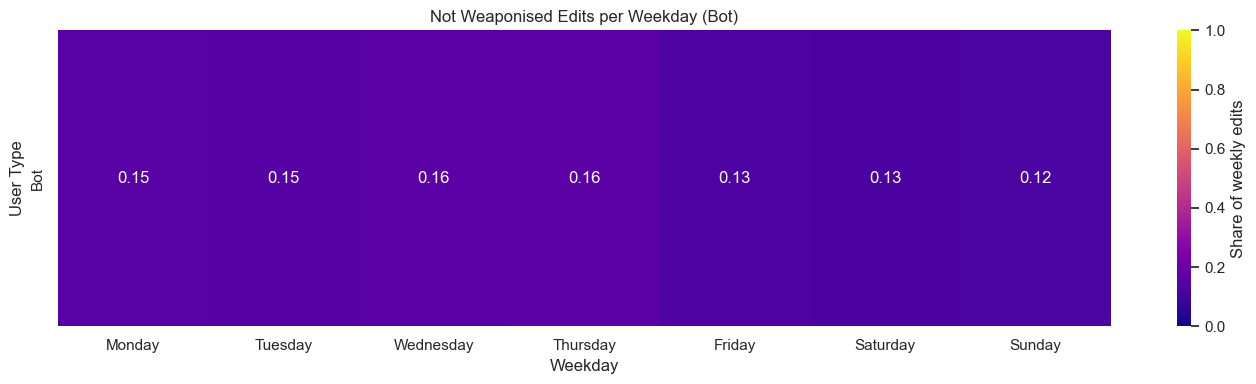

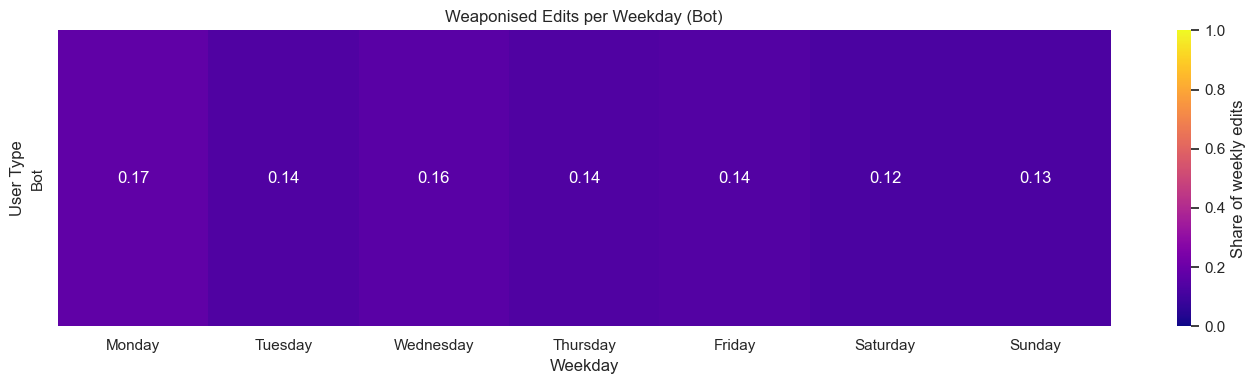

(weekday_name    Monday  Tuesday  Wednesday  Thursday   Friday  Saturday  \
 user_type                                                                 
 Bot           0.153494  0.14975   0.156406  0.160566  0.13228   0.12604   
 
 weekday_name    Sunday  
 user_type               
 Bot           0.121464  ,
 weekday_name   Monday   Tuesday  Wednesday  Thursday    Friday  Saturday  \
 user_type                                                                  
 Bot           0.17433  0.136015   0.157088  0.136015  0.143678  0.124521   
 
 weekday_name    Sunday  
 user_type               
 Bot           0.128352  )

In [12]:
def plot_heatmap_weekdays_user_type(
    dataframe,
    user_type="Anonymous (IP)",
    normalize=True,
    wanna_save=False,
    save_path="../../plots/Full Database/"
):
    """
    Plot weekday heatmaps for weaponised vs not weaponised edits.
    Normalisation is row-wise (distribution across weekdays).
    """

    df = dataframe.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["weekday_name"] = df["date"].dt.day_name()
    df = df[df["user_type"] == user_type]

    ordered_days = [
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ]

    def prepare_heatmap(df_subset):
        hm = (
            df_subset
            .groupby(["user_type", "weekday_name"])
            .size()
            .reset_index(name="count")
            .pivot_table(
                index="user_type",
                columns="weekday_name",
                values="count",
                aggfunc="sum"
            )
            .reindex(columns=ordered_days, fill_value=0)
        )

        if normalize:
            hm = hm.div(hm.sum(axis=1), axis=0)

        return hm

    # Split datasets
    hm_not = prepare_heatmap(df[df["weaponised"] == "Not Weaponised"])
    hm_weap = prepare_heatmap(df[df["weaponised"] != "Not Weaponised"])

    def plot_heatmap(hm, title, filename):
        plt.figure(figsize=(14, 4))
        sns.heatmap(
            hm,
            cmap="plasma",
            vmin=0 if normalize else None,
            vmax=1 if normalize else None,
            annot=True,
            fmt=".2f" if normalize else "g",
            cbar_kws={
                "label": "Share of weekly edits" if normalize else "Edit count"
            }
        )
        plt.xlabel("Weekday")
        plt.ylabel("User Type")
        plt.title(title)
        plt.tight_layout()

        if wanna_save:
            plt.savefig(
                f"{save_path}{filename}.png",
                dpi=300,
                bbox_inches="tight"
            )

        plt.show()

    # Plot
    plot_heatmap(
        hm_not,
        f"Not Weaponised Edits per Weekday ({user_type})",
        f"heatmap_not_weaponised_{user_type}"
    )

    plot_heatmap(
        hm_weap,
        f"Weaponised Edits per Weekday ({user_type})",
        f"heatmap_weaponised_{user_type}"
    )

    return hm_not, hm_weap

plot_heatmap_weekdays_user_type(df_preprocessed, 'Bot', True, False)